In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = "./Dataset/"
mmscaler = MinMaxScaler(feature_range=(-1, 1), copy=True)

#training set
train_ax = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/body_acc_x_train.txt"))
train_ay = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/body_acc_y_train.txt"))
train_az = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/body_acc_z_train.txt"))
train_gx = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/body_gyro_x_train.txt"))
train_gy = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/body_gyro_y_train.txt"))
train_gz = mmscaler.fit_transform(np.loadtxt(path + "train/Inertial Signals/body_gyro_z_train.txt"))

train_t = np.loadtxt(path + "train/y_train.txt").astype(int)
train_s = np.loadtxt(path + "train/subject_train.txt").astype(int)

#test set
test_ax = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/body_acc_x_test.txt"))
test_ay = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/body_acc_y_test.txt"))
test_az = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/body_acc_z_test.txt"))
test_gx = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/body_gyro_x_test.txt"))
test_gy = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/body_gyro_y_test.txt"))
test_gz = mmscaler.fit_transform(np.loadtxt(path + "test/Inertial Signals/body_gyro_z_test.txt"))

test_t = np.loadtxt(path + "test/y_test.txt").astype(int)
test_s = np.loadtxt(path + "test/subject_test.txt").astype(int)

print(train_t)

[5 5 5 ... 2 2 2]


In [5]:
train_size = 7352
test_size = 2947
dim_size = 6
sample_size = 128

In [6]:
# trX = (7352, 128, 3) ... trainのX
trX = np.ones((train_size, sample_size, dim_size), float)
print('trX.shape initial:{0}'.format(trX.shape))
for i in range(train_size):
  #temp1 = np.ones((dim_size, sample_size), float)
  trX[i,:,0] = train_ax[i,:]
  trX[i,:,1] = train_ay[i,:]
  trX[i,:,2] = train_az[i,:]
  trX[i,:,3] = train_gx[i,:]
  trX[i,:,4] = train_gy[i,:]
  trX[i,:,5] = train_gz[i,:]
  
print('trX.shape assigned:{0}'.format(trX.shape))


# t(movement label) or s(subject label) or both ... trainのY (7352,1)
trY = train_t.reshape(-1,1)

# teX = (2947, 3, 128) ... testのX
teX = np.ones((test_size, sample_size, dim_size), float)
print('teX.shape initial:{0}'.format(teX.shape))
for i in range(test_size):
  #temp2 = np.ones((dim_size, sample_size), float)
  teX[i,:,0] = test_ax[i,:]
  teX[i,:,1] = test_ay[i,:]
  teX[i,:,2] = test_az[i,:]
  teX[i,:,3] = test_gx[i,:]
  teX[i,:,4] = test_gy[i,:]
  teX[i,:,5] = test_gz[i,:]
  
print('trX.shape assigned:{0}'.format(teX.shape))

# testのY 2947行1列
teY = test_t.reshape(-1,1)

trX.shape initial:(7352, 128, 6)
trX.shape assigned:(7352, 128, 6)
teX.shape initial:(2947, 128, 6)
trX.shape assigned:(2947, 128, 6)


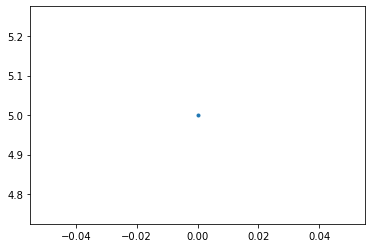

In [7]:
plt.plot(train_t[0], '.', label = "train_ax")
plt.plot(trY[0])
plt.show()

In [8]:
datax = np.vstack([trX, teX])
print('datax.shape:{0}'.format(datax.shape))
datay = np.vstack([trY, teY])
print('datay.shape:{0}'.format(datay.shape))
# dataX = trX and teX (10299, 3, 128)
dataX = torch.Tensor(np.array(datax)).to(device)
# dataY = trY and teY (10299,1)
dataY = torch.Tensor(np.array(datay)).to(device)

trainX = torch.Tensor(np.array(trX)).to(device)
trainY = torch.Tensor(np.array(trY)).to(device)

testX = torch.Tensor(np.array(teX)).to(device)
testY = torch.Tensor(np.array(teY)).to(device)

# trainYをone-hotにするためlongにして1次元配列に戻す　-> min~maxを0~5に直す
trainY = trainY.view(-1).long() - 1
print(trainY.shape)
print(torch.min(trainY), torch.max(trainY))

# one-hotにする -> 誤差を計算できるようにfloatに直す
trainY = F.one_hot(trainY, num_classes=-1)
trainY = trainY.float()
print(trainY.shape)
print(trainY)
trY = trainY.cpu().data.numpy()
print(trY.shape)
#print(trainX)
testY = testY.view(-1).long() - 1
# testY = F.one_hot(testY, num_classes=-1)
# testY = testY.float()

datax.shape:(10299, 128, 6)
datay.shape:(10299, 1)
torch.Size([7352])
tensor(0, device='cuda:0') tensor(5, device='cuda:0')
torch.Size([7352, 6])
tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], device='cuda:0')
(7352, 6)


In [9]:
print(testX.shape)
print(testY)

torch.Size([2947, 128, 6])
tensor([4, 4, 4,  ..., 1, 1, 1], device='cuda:0')


## Dataset & Dataloader

In [10]:
class DataSet:
    def __init__(self):
        self.X = trX.astype(np.float32) # 入力
        self.t = trY # 出力

    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.t[index]

In [11]:
dataset = DataSet()
print('全データ数:',len(dataset))
# print('3番目のデータ:',dataset[3]) 

全データ数: 7352


In [12]:
# さっき作ったDataSetクラスのインスタンスを作成
dataset = DataSet()
# datasetをDataLoaderの引数とすることでミニバッチを作成．
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, \
                                         shuffle=True, drop_last=True)

In [13]:
class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size_1 = 50
        self.hidden_size_2 = 70
        self.lstm_1 = nn.LSTM(input_size=6, hidden_size=self.hidden_size_1, num_layers=1, batch_first=True) 
        self.lstm_2 = nn.LSTM(input_size=self.hidden_size_1, hidden_size=self.hidden_size_2, num_layers=1, batch_first=True) 
        self.relu = nn.ReLU()
        self.linear = nn.Linear(70, 6)
        #self.softmax = nn.Softmax(-1)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size_1).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size_1).to(device)
        h_1 = torch.zeros(1, x.size(0), self.hidden_size_2).to(device)
        c_1 = torch.zeros(1, x.size(0), self.hidden_size_2).to(device)
        out, (h_out, c_out) = self.lstm_1(x, (h_0, c_0))
        _, (h_out, _) = self.lstm_2(out, (h_1, c_1))
        h_out = h_out.view(-1, self.hidden_size_2)
        h_out = self.relu(h_out)
        y_hat = self.linear(h_out)
        #y_hat = self.softmax(h_out)
        return y_hat


#print(summary(MyLSTM(), input_size=(7352, 128, 3), device=torch.device(device)))  

In [14]:
def train(model, optimizer, X, t):
  model.train()
  y_hat = model(X)
  # print(y_hat.shape)
  # loss = F.mse_loss(y_hat, trainY)
  loss = nn.CrossEntropyLoss()
  output = loss(y_hat, t)
  optimizer.zero_grad()
  output.backward()
  optimizer.step()
  return output.item()

loss = []

def main():
  model = MyLSTM()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  model = model.to(device)

  for epoch in range(200):
    for X, t in dataloader:
      _loss = train(model, optimizer, X.to(device), t.to(device))
      loss.append(_loss)
    if epoch % 20 == 0:
      print(f"Epoch = {epoch+1}, Loss = {_loss:.5f}")
  return model

In [15]:
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

# create default optimizer for doctests

param_tensor = torch.zeros([1], requires_grad=True)
default_optimizer = torch.optim.SGD([param_tensor], lr=0.1)

# create default trainer for doctests
# as handlers could be attached to the trainer,
# each test must define his own trainer using `.. testsetup:`

def get_default_trainer():

    def train_step(engine, batch):
        return batch

    return Engine(train_step)

# create default model for doctests

# default_model = nn.Sequential(OrderedDict([
#     ('base', nn.Linear(4, 2)),
#     ('fc', nn.Linear(2, 1))
# ]))

# manual_seed(666)

In [16]:
model = main()

Epoch = 1, Loss = 1.77764
Epoch = 21, Loss = 1.78448
Epoch = 41, Loss = 1.78429
Epoch = 61, Loss = 1.76743
Epoch = 81, Loss = 1.77396
Epoch = 101, Loss = 1.77948
Epoch = 121, Loss = 1.75478
Epoch = 141, Loss = 1.76921
Epoch = 161, Loss = 1.78075
Epoch = 181, Loss = 1.77484


In [17]:
def predict(model):
  model.eval()
  train_predict = model(testX)
  print(train_predict.shape)

  #data_predict = train_predict.cpu().data.numpy()
  #testY_plot = testY.cpu().data.numpy()

  
  data_predict = torch.argmax(train_predict, dim=-1)
  data_predict = F.one_hot(data_predict, num_classes=6)
  
  metric = ConfusionMatrix(num_classes=6)
  metric.attach(default_evaluator, 'cm')
  y_true = testY.view(-1).int()
  y_pred = data_predict
  print(y_true.shape)
  print(y_pred.shape)

  state = default_evaluator.run([[y_pred, y_true]])
  print(state.metrics['cm'])


In [18]:
predict(model)

torch.Size([2947, 6])
torch.Size([2947])
torch.Size([2947, 6])
tensor([[  0,   0,   0,   0,   0, 496],
        [  0,   0,   0,   0,   0, 471],
        [  0,   0,   0,   0,   0, 420],
        [  0,   0,   0,   0,   0, 491],
        [  0,   0,   0,   0,   0, 532],
        [  0,   0,   0,   0,   0, 537]])


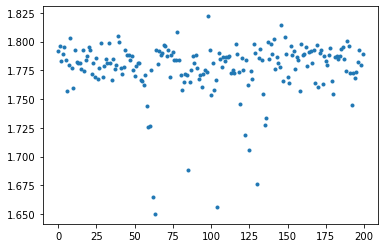

In [20]:
stop = len(loss)
step = int(len(loss) / 200)
plt.plot(loss[0:stop:step], '.', label = "test_error")
plt.show()

In [ ]:
model_path = 'walkDetectModel.pth'
torch.save(model.state_dict(), model_path)